Starting CMA-ES (vectorized batch evaluations)...
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=788321, Tue Sep 23 20:10:18 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.416606893986868e+00 1.0e+00 3.44e-01  3e-01  4e-01 3:45.2
    2     16 1.094309919540175e+00 1.5e+00 3.96e-01  4e-01  5e-01 7:44.1
    3     24 1.739634574198527e+00 1.9e+00 3.83e-01  3e-01  5e-01 11:10.4
    4     32 1.173254443146389e+00 2.0e+00 3.96e-01  3e-01  5e-01 15:18.8
    5     40 8.225260671871338e-01 2.1e+00 4.14e-01  3e-01  5e-01 20:57.8
    6     48 5.729106875703188e-01 2.1e+00 4.24e-01  3e-01  5e-01 27:33.9
    7     56 2.609402723127400e-01 2.1e+00 5.07e-01  4e-01  8e-01 33:32.6
    8     64 3.287887148768836e-01 2.9e+00 5.22e-01  4e-01  8e-01 39:22.8
    9     72 2.612616234809874e-01 3.0e+00 4.81e-01  4e-01  7e-01 45:01.3
   10     80 2.629426849635399e-01 3.0e+00 4.54e-01  3e-01  6e-01 50:01.1
Iterat #Fevals   function value  axis ratio  sigma

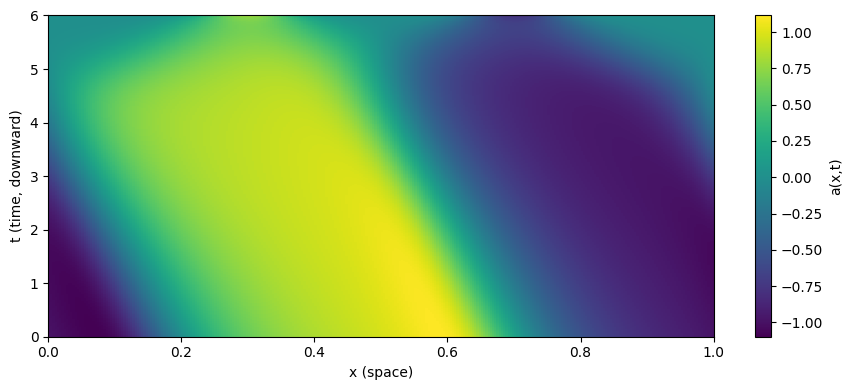

In [1]:
"""
Criticality training for a two-field RAD system (vectorized over batch seeds)

PDE (sign-unbiased in a; conservative advection; fixed memory timescale):
    m_t = alpha_m * (a - m)
    a_t =  mu * a - gamma * a**3 + rho * (m - a)  - d/dx ( alpha_k * a**2 * m ) + D * a_xx
with the constraint mu = gamma  (so uniform ODE equilibria are a*=0, ±1).

We tune {D, alpha_k, gamma(=mu), rho} using CMA-ES toward "edge-of-chaos" metrics.
Vectorized batch integration avoids threading: arrays are (B, nx), rolled along axis=-1.
"""

import math
import numpy as np
import matplotlib.pyplot as plt

# CMA-ES (pycma)
try:
    import cma
except ImportError as e:
    raise SystemExit("This script requires 'pycma'. Install with:  pip install cma") from e


# =============================== Model =============================== #
class TwoFieldRADBatch:
    """
    Vectorized two-field RAD model on 1D periodic grid.

    State per batch member b: a[b, x], m[b, x]
    m_t = alpha_m (a - m)
    a_t = gamma * a - gamma * a**3 + rho * (m - a)  - d_x( alpha_k * a**2 * m ) + D a_xx
    (mu = gamma)

    Numerics:
      - Periodic BCs
      - RK4 time integration, single dt used for the whole batch (min-CFL over batch & perturbed batch if FTLE on)
      - Conservative advection via Rusanov flux on F = alpha_k * a^2 * m
        characteristic speed ~ |dF/da| = |2 * alpha_k * a * m|
      - Diffusion via 2nd-order Laplacian
      - Uniform output frames (for diagnostics)

    Vectorized shapes:
      a, m: (B, nx)
      rolls are along axis=-1
    """

    def __init__(self, nx=300, L=1.0, T_final=5.0, n_frames=500, CFL=0.4, alpha_m=1.0, seed=0):
        self.nx = int(nx)
        self.L = float(L)
        self.dx = self.L / self.nx
        self.x = np.linspace(0.0, self.L, self.nx, endpoint=False)

        self.T_final = float(T_final)
        self.n_frames = int(n_frames)
        self.CFL = float(CFL)

        self.alpha_m = float(alpha_m)  # fixed memory timescale

        # trainable parameters (set via set_params)
        self.D = 1e-2
        self.alpha_k = 0.8
        self.gamma = 0.8          # also mu
        self.rho = 0.4

        self.rng = np.random.default_rng(seed)

    # ---------- numerical building blocks (vectorized over batch) ---------- #
    def _laplacian(self, u):
        # u: (B, nx)
        return (np.roll(u, -1, axis=-1) - 2.0 * u + np.roll(u, 1, axis=-1)) / (self.dx * self.dx)

    def _adv_flux_div_rusanov(self, a, m):
        """
        Compute -∂x F with Rusanov flux for F = alpha_k * a^2 * m, all batch-wise.
        a, m: (B, nx)
        Returns: div: (B, nx)
        """
        F = self.alpha_k * (a * a) * m                       # (B, nx)
        Fp = np.roll(F, -1, axis=-1)

        # local speed amax at interfaces i+1/2: max(|dF/da|_L, |dF/da|_R)
        sL = 2.0 * self.alpha_k * a * m                      # (B, nx)
        sR = np.roll(sL, -1, axis=-1)
        amax = np.maximum(np.abs(sL), np.abs(sR))            # (B, nx)

        # Rusanov flux H_{i+1/2}
        H = 0.5 * (F + Fp) - 0.5 * amax * (np.roll(a, -1, axis=-1) - a)
        Hm = np.roll(H, 1, axis=-1)

        return - (H - Hm) / self.dx

    def _rhs(self, a, m):
        # reaction (mu = gamma)
        mu = self.gamma
        reaction = mu * a - self.gamma * (a * a * a) + self.rho * (m - a)
        adv = self._adv_flux_div_rusanov(a, m)
        diff = self.D * self._laplacian(a)
        a_t = reaction + adv + diff
        m_t = self.alpha_m * (a - m)
        return a_t, m_t

    def _stable_dt_batch(self, a, m):
        """
        Compute a single dt satisfying CFL over the whole batch.
        Returns scalar dt bound (before multiplying by CFL).
        """
        bounds = []

        vmax = np.max(np.abs(2.0 * self.alpha_k * a * m))  # over all b,x
        if vmax > 1e-14:
            bounds.append(self.dx / vmax)

        if self.D > 0.0:
            bounds.append(self.dx * self.dx / (2.0 * self.D))

        # reaction Lipschitz bound across batch
        Lr = np.max(np.abs(self.gamma - 3.0 * self.gamma * (a * a) - self.rho)) + np.abs(self.rho)
        if Lr > 1e-14:
            bounds.append(1.0 / Lr)

        if self.alpha_m > 0.0:
            bounds.append(1.0 / self.alpha_m)

        if not bounds:
            return 0.01 * self.T_final
        return min(bounds)

    def set_params(self, D, alpha_k, gamma, rho):
        self.D = float(D)
        self.alpha_k = float(alpha_k)
        self.gamma = float(gamma)
        self.rho = float(rho)

    # -------------------------- batched ICs -------------------------- #
    def reset_batch(self, seeds=(0, 1, 2), include_mirror=True):
        """
        Create a batch of ICs of size B = len(seeds) * (1 + include_mirror).
        a0, m0 shapes: (B, nx).  m0 set to 0 (no asymmetry).
        """
        a_list = []
        for s in seeds:
            rng = np.random.default_rng(s)
            a0 = (
                np.exp(-((self.x - 0.30 * self.L) ** 2) / (2.0 * (0.05 * self.L) ** 2)) * (+0.8)
                + np.exp(-((self.x - 0.70 * self.L) ** 2) / (2.0 * (0.05 * self.L) ** 2)) * (-0.8)
            )
            a0 += 0.04 * (rng.random(self.x.shape) - 0.5) * 2.0
            a0 = np.clip(a0, -1.0, 1.0)
            a_list.append(a0)
            if include_mirror:
                a_list.append(-a0)

        a0 = np.stack(a_list, axis=0)                      # (B, nx)
        m0 = np.zeros_like(a0)                             # (B, nx)
        return a0, m0

    # --------------------- batched integration ---------------------- #
    def integrate_batch(self, a0, m0, store_frames=True):
        """
        Integrate the whole batch with a single dt per step.

        Returns:
          frames_a: (T, B, nx) if store_frames else None
          frames_m: (T, B, nx) if store_frames else None
          ts: (T,)
        """
        a = a0.copy()
        m = m0.copy()

        if store_frames:
            ts = np.linspace(0.0, self.T_final, self.n_frames)
            frames_a = np.zeros((self.n_frames, a.shape[0], self.nx), dtype=np.float64)
            frames_m = np.zeros_like(frames_a)
            frames_a[0] = a
            frames_m[0] = m
            fi = 1
            t_target = ts[fi] if fi < self.n_frames else self.T_final
        else:
            ts = None
            frames_a = frames_m = None
            fi = 0
            t_target = self.T_final

        t = 0.0
        while t < self.T_final - 1e-14:
            dt_bound = self._stable_dt_batch(a, m)
            dt = self.CFL * dt_bound
            dt = min(dt, t_target - t)
            dt = max(dt, 1e-12)

            # RK4 batched
            a1, m1 = self._rhs(a, m)
            a2, m2 = self._rhs(a + 0.5 * dt * a1, m + 0.5 * dt * m1)
            a3, m3 = self._rhs(a + 0.5 * dt * a2, m + 0.5 * dt * m2)
            a4, m4 = self._rhs(a + dt * a3,     m + dt * m3)
            a = a + (dt / 6.0) * (a1 + 2 * a2 + 2 * a3 + a4)
            m = m + (dt / 6.0) * (m1 + 2 * m2 + 2 * m3 + m4)

            t += dt

            if store_frames and t >= t_target - 1e-14:
                frames_a[fi] = a
                frames_m[fi] = m
                fi += 1
                if fi >= self.n_frames:
                    break
                t_target = ts[fi]

        return frames_a, frames_m, ts

    def integrate_batch_with_ftle(self, a0, m0, eps=1e-6, ftle_samples=40):
        """
        Integrate the batch AND a perturbed copy for FTLE concurrently (same dt per step).

        Returns:
          frames_a, frames_m, ts  (as integrate_batch)
          ftle_times, ftle_deltas: (S, B) early-window samples for log-slope regression
        """
        B = a0.shape[0]
        a = a0.copy()
        m = m0.copy()
        rng = np.random.default_rng(12345)
        a_p = a0 + eps * rng.standard_normal(size=a0.shape)
        m_p = m0.copy()

        ts = np.linspace(0.0, self.T_final, self.n_frames)
        frames_a = np.zeros((self.n_frames, B, self.nx), dtype=np.float64)
        frames_m = np.zeros_like(frames_a)
        frames_a[0] = a
        frames_m[0] = m
        fi = 1
        t_target = ts[fi] if fi < self.n_frames else self.T_final

        # FTLE sample times (early window)
        early_horizon = min(self.T_final * 0.4, 2.0)
        ftle_ts = np.linspace(0.0, early_horizon, ftle_samples)
        si = 1  # skip 0
        next_ftle_t = ftle_ts[si] if si < ftle_ts.size else self.T_final
        ftle_times = [0.0]
        ftle_deltas = [np.linalg.norm((a_p - a).reshape(B, -1), axis=1)]  # (B,)

        t = 0.0
        while t < self.T_final - 1e-14:
            # conservative dt across base + perturbed
            dt_bound1 = self._stable_dt_batch(a, m)
            dt_bound2 = self._stable_dt_batch(a_p, m_p)
            dt = self.CFL * min(dt_bound1, dt_bound2)
            dt = min(dt, t_target - t, next_ftle_t - t)
            dt = max(dt, 1e-12)

            # base
            a1, m1 = self._rhs(a, m)
            a2, m2 = self._rhs(a + 0.5 * dt * a1, m + 0.5 * dt * m1)
            a3, m3 = self._rhs(a + 0.5 * dt * a2, m + 0.5 * dt * m2)
            a4, m4 = self._rhs(a + dt * a3,     m + dt * m3)
            a = a + (dt / 6.0) * (a1 + 2 * a2 + 2 * a3 + a4)
            m = m + (dt / 6.0) * (m1 + 2 * m2 + 2 * m3 + m4)

            # perturbed
            ap1, mp1 = self._rhs(a_p, m_p)
            ap2, mp2 = self._rhs(a_p + 0.5 * dt * ap1, m_p + 0.5 * dt * mp1)
            ap3, mp3 = self._rhs(a_p + 0.5 * dt * ap2, m_p + 0.5 * dt * mp2)
            ap4, mp4 = self._rhs(a_p + dt * ap3,      m_p + dt * mp3)
            a_p = a_p + (dt / 6.0) * (ap1 + 2 * ap2 + 2 * ap3 + ap4)
            m_p = m_p + (dt / 6.0) * (mp1 + 2 * mp2 + 2 * mp3 + mp4)

            t += dt

            if t >= t_target - 1e-14:
                frames_a[fi] = a
                frames_m[fi] = m
                fi += 1
                if fi >= self.n_frames:
                    # also collect any pending FTLE sample before break
                    while si < ftle_ts.size and t >= next_ftle_t - 1e-14:
                        ftle_times.append(t)
                        ftle_deltas.append(np.linalg.norm((a_p - a).reshape(B, -1), axis=1))
                        si += 1
                        next_ftle_t = ftle_ts[si] if si < ftle_ts.size else self.T_final + 1.0
                    break
                t_target = ts[fi]

            if t >= next_ftle_t - 1e-14:
                ftle_times.append(t)
                ftle_deltas.append(np.linalg.norm((a_p - a).reshape(B, -1), axis=1))
                si += 1
                next_ftle_t = ftle_ts[si] if si < ftle_ts.size else self.T_final + 1.0

        ftle_times = np.array(ftle_times)        # (S,)
        ftle_deltas = np.stack(ftle_deltas, 0)   # (S, B)
        return frames_a, frames_m, ts, ftle_times, ftle_deltas


# ============================ Diagnostics ============================ #
def mid_occupancy(frames_a, low=0.2, high=0.8):
    # frames_a: (T, B, nx) -> scalar fraction
    A = np.abs(frames_a)
    return float(np.mean((A >= low) & (A <= high)))


def symmetry_metrics(frames_a):
    # scalar summaries over time, batch, space
    mean_a = float(np.mean(frames_a))
    pos_frac = float(np.mean(frames_a > 0.0))
    a3 = np.mean(frames_a ** 3)
    denom = np.mean(np.abs(frames_a) ** 3) + 1e-12
    skew = float(a3 / denom)
    return mean_a, pos_frac, skew


def transport_speeds(frames_a, ts, sample_rows=30):
    """
    Estimate phase speeds per batch via argmax of circular cross-correlation between
    consecutive frames in the last third of the movie.
    Returns:
      c_list_abs_median: median(|c|) across batch/time
      sign_balance: fraction of positive speeds (~0.5 desired)
    """
    T, B, nx = frames_a.shape
    if T < 3:
        return 0.0, 0.5

    start = (2 * T) // 3
    idxs = np.arange(start, T - 1)
    dx = 1.0 / nx  # domain is [0,1) in extent mapping; we’ll correct if needed externally

    c_vals = []
    for i in idxs:
        a0 = frames_a[i]     # (B, nx)
        a1 = frames_a[i + 1] # (B, nx)
        # zero-mean each row
        a0z = a0 - np.mean(a0, axis=1, keepdims=True)
        a1z = a1 - np.mean(a1, axis=1, keepdims=True)
        A0 = np.fft.rfft(a0z, axis=1)
        A1 = np.fft.rfft(a1z, axis=1)
        cc = np.fft.irfft(A0 * np.conj(A1), n=nx, axis=1)   # (B, nx)
        shifts = np.argmax(cc, axis=1)                      # (B,)
        # map large shifts to negative
        shifts = np.where(shifts > nx // 2, shifts - nx, shifts)
        dt = ts[i + 1] - ts[i]
        c = (shifts * dx) / (dt + 1e-12)                    # (B,)
        c_vals.append(c)

    if not c_vals:
        return 0.0, 0.5
    c_all = np.concatenate(c_vals, axis=0)
    return float(np.median(np.abs(c_all))), float(np.mean(c_all > 0.0))


def ftle_from_samples(ftle_times, ftle_deltas):
    """
    ftle_times: (S,), ftle_deltas: (S, B) L2 norms of (a_p - a).
    Returns median slope across batch over the first ~10 samples (excluding t=0).
    """
    if ftle_times.size < 3:
        return 0.0
    x = ftle_times
    # use first 10 nonzero
    idx = slice(1, min(12, x.size))
    xs = x[idx]
    denom = np.dot(xs - xs.mean(), xs - xs.mean()) + 1e-12

    slopes = []
    for b in range(ftle_deltas.shape[1]):
        y = np.log(np.maximum(ftle_deltas[:, b], 1e-30))
        ys = y[idx]
        slope = float(np.dot(xs - xs.mean(), ys - ys.mean()) / denom)
        slopes.append(slope)
    return float(np.median(slopes))


# ============================== Loss ================================= #
def evaluate_theta(theta, model: TwoFieldRADBatch, seeds=(0, 1, 2), q_cells=6):
    """
    Vectorized evaluation of a parameter vector theta on a batch of seeds.

    theta = [logD, log_ck, log_gamma, log1p_rho]
      D       = exp(logD)
      alpha_k = ck * D / (q_cells * dx)
      gamma   = exp(log_gamma)  (mu = gamma)
      rho     = exp(log1p_rho) - 1

    Returns: (loss, info-dict)
    """
    logD, log_ck, log_gamma, log1p_rho = theta

    D = float(np.exp(logD))
    ck = float(np.exp(log_ck))
    gamma = float(np.exp(log_gamma))
    rho = float(np.exp(log1p_rho) - 1.0)

    alpha_k = ck * D / (q_cells * model.dx)
    model.set_params(D=D, alpha_k=alpha_k, gamma=gamma, rho=rho)

    # soft parameter penalties (keep within sensible, resolvable ranges)
    pen = 0.0
    pen += 10.0 * max(0.0, math.log10(max(D, 1e-16)) - math.log10(2e-2)) ** 2
    pen += 10.0 * max(0.0, math.log10(5e-4) - math.log10(max(D, 1e-16))) ** 2
    pen += 2.0 * max(0.0, ck - 1.6) ** 2 + 2.0 * max(0.0, 0.5 - ck) ** 2
    pen += 1.0 * max(0.0, rho - 3.0) ** 2 + 1.0 * max(0.0, -rho) ** 2
    pen += 1.0 * max(0.0, gamma - 2.5) ** 2 + 1.0 * max(0.0, 0.05 - gamma) ** 2

    # Build batch ICs (mirrors included to test sign symmetry)
    a0, m0 = model.reset_batch(seeds=seeds, include_mirror=True)

    # Integrate base + perturbed together for FTLE
    frames_a, frames_m, ts, ftle_ts, ftle_deltas = model.integrate_batch_with_ftle(
        a0, m0, eps=1e-6, ftle_samples=40
    )

    # Consider last 60% for most metrics
    j0 = int(0.4 * model.n_frames)
    A = frames_a[j0:]               # (T2, B, nx)
    M = frames_m[j0:]

    # (1) boundedness (worst across time/batch)
    Amax = float(np.max(np.abs(A)))
    Mmax = float(np.max(np.abs(M)))

    # (2) mid-occupancy (non-triviality)
    pmid = mid_occupancy(A, 0.2, 0.8)

    # (3) symmetry
    mean_a, pos_frac, skew = symmetry_metrics(A)

    # (4) transport
    # Note: transport_speeds assumes domain length 1 in its dx; scale if needed
    c_med_abs, c_pos_balance = transport_speeds(A, ts[j0:], sample_rows=30)
    # correct dx scale if L != 1
    c_med_abs *= (model.L)

    # (5) FTLE
    ftle = ftle_from_samples(ftle_ts, ftle_deltas)

    # Compose loss
    loss = 0.0
    # boundedness: soft wall
    loss += 5.0 * max(0.0, Amax - 1.8) ** 2
    loss += 2.0 * max(0.0, Mmax - 2.0) ** 2
    # mid occupancy in [0.25, 0.6]
    if pmid < 0.25:
        loss += (0.25 - pmid) ** 2 * 2.0
    if pmid > 0.60:
        loss += (pmid - 0.60) ** 2 * 2.0
    # symmetry
    loss += 2.0 * (abs(mean_a) ** 2)
    loss += 1.5 * (pos_frac - 0.5) ** 2
    loss += 0.5 * (skew ** 2)
    # FTLE small positive target ~0.05
    target_ftle = 0.05
    loss += 1.5 * (ftle - target_ftle) ** 2 + 1.5 * max(0.0, 0.0 - ftle) ** 2
    # transport: want measurable but not huge; and balanced sign
    if c_med_abs < 0.05:
        loss += (0.05 - c_med_abs) ** 2 * 1.0
    if c_med_abs > 1.5:
        loss += (c_med_abs - 1.5) ** 2 * 0.5
    loss += 1.0 * (c_pos_balance - 0.5) ** 2

    loss += pen

    info = dict(
        D=D, ck=ck, alpha_k=alpha_k, gamma=gamma, rho=rho,
        Amax=Amax, Mmax=Mmax, pmid=pmid, mean_a_abs=abs(mean_a),
        pos_frac_mean=pos_frac, skew_mean=skew,
        ftle=ftle, c_med_abs=c_med_abs, c_pos_balance=c_pos_balance,
        loss=loss,
    )
    return loss, info


# ============================= Training ============================== #

"""
Single-stage CMA-ES using vectorized batch evaluations.
You can later add a multi-fidelity schedule by changing nx/T_final/n_frames and seeds.
"""
# Fast-ish stage settings (tune up later)
model = TwoFieldRADBatch(
    nx=300, L=1.0, T_final=6.0, n_frames=500, CFL=0.4,
    alpha_m=0.5, seed=123
)

# CMA variables: theta = [logD, log_ck, log_gamma, log1p_rho]
x0 = np.array([
    math.log(0.01),    # D
    math.log(0.9),     # ck (alpha_k = ck * D / (q * dx))
    math.log(0.8),     # gamma (mu=gamma)
    math.log1p(0.4),   # rho
], dtype=float)
sigma0 = 0.3

opts = {
    "maxfevals": 96,   # tweak up as needed
    "verb_disp": 1,
    "verb_time": 1
    # leave popsize default (lambda=8 in 4D); vectorization already speeds up each eval
}

seeds = (0, 1)  # batch = 2 * (1 + mirror) = 4 initial conditions
q_cells = 6

def objective(theta):
    loss, _ = evaluate_theta(theta, model, seeds=seeds, q_cells=q_cells)
    return loss

print("Starting CMA-ES (vectorized batch evaluations)...")
es = cma.CMAEvolutionStrategy(x0, sigma0, opts)
res = es.optimize(objective)
best_theta = res.result.xbest
best_loss = res.result.fbest

# Re-evaluate best on a slightly larger batch for a more stable readout
seeds_val = (2, 3)
loss, info = evaluate_theta(best_theta, model, seeds=seeds_val, q_cells=q_cells)

print("\n=== Best found (re-evaluated) ===")
for k in ("D", "ck", "alpha_k", "gamma", "rho", "loss",
            "Amax", "Mmax", "pmid", "mean_a_abs", "pos_frac_mean", "skew_mean",
            "ftle", "c_med_abs", "c_pos_balance"):
    print(f"{k:>14}: {info[k]:.6g}")

# Optional: visualize one batch trajectory with the best params
# Build a new model with finer settings if you like
vis_model = TwoFieldRADBatch(nx=300, L=1.0, T_final=6.0, n_frames=400, CFL=0.4, alpha_m=0.3, seed=2025)
alpha_k = info["alpha_k"]
vis_model.set_params(D=info["D"], alpha_k=alpha_k, gamma=info["gamma"], rho=info["rho"])

a0, m0 = vis_model.reset_batch(seeds=(10,), include_mirror=True)  # B=2 (seed & mirror)
frames_a, frames_m, ts = vis_model.integrate_batch(a0, m0, store_frames=True)

# plot 'a' for the first batch member
extent = (0.0, vis_model.L, 0.0, vis_model.T_final)
fig, ax = plt.subplots(figsize=(9, 4))
im = ax.imshow(frames_a[:, 0, :], aspect='auto', origin='upper', extent=extent, interpolation='nearest')
ax.set_xlabel("x (space)")
ax.set_ylabel("t (time, downward)")
plt.colorbar(im, ax=ax, label="a(x,t)")
plt.tight_layout()
plt.show()

In [2]:
es.result.xbest

array([-4.90556029, -0.37677339,  0.88450629,  0.3550252 ])

In [3]:
logD, log_ck, log_gamma, log1p_rho = es.result.xbest
print(float(np.exp(logD))) #D
print(float(np.exp(log_ck))) #cK
print(float(np.exp(log_gamma))) #gamma         # mu = gamma
print(float(np.exp(log1p_rho) - 1.0)) #rho


0.0074052927988183526
0.6860715300893099
2.4217884392113165
0.4262166000201546


In [4]:
q_cells

6